# 鲍鱼年龄预测——XGBoost调参策略
姓名：邹子涵  
学号：202020085400139  
数据集基于Abalone Data Set：  
* [鲍鱼年龄预测数据集——数据来源UCI机器学习数据库](https://archive.ics.uci.edu/ml/datasets/Abalone)

## 一、导入依赖

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
import xgboost as xgb
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 二、导入数据集

In [2]:
data = pd.read_csv('dataset/abalone.data',header=None,names=['Sex','Length','Diameter','Height','Whole-weight','Shucked-weight','Viscera-weight','Shell-weight','Rings'])
n = len(data)+1
nlist = range(1,n)
data['id'] = nlist
data.loc[(data['Sex']=="M"),'Sex']=0
data.loc[(data['Sex']=="F"),'Sex']=1
data.loc[(data['Sex']=="I"),'Sex']=2
data

,Sex,Length,Diameter,Height,Whole-weight,Shucked-weight,Viscera-weight,Shell-weight,Rings,id
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,1
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,2
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,3
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,4
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,5
...,...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,4173
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,4174
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,4175
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,4176


查看数据集特征

In [3]:
print('columns:',list(data.columns[:]))

columns: ['Sex', 'Length', 'Diameter', 'Height', 'Whole-weight', 'Shucked-weight', 'Viscera-weight', 'Shell-weight', 'Rings', 'id']


查看数据集描述

In [4]:
data.describe()

,Length,Diameter,Height,Whole-weight,Shucked-weight,Viscera-weight,Shell-weight,Rings,id
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,2089.000000
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,1205.940366
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,1045.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,2089.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,3133.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,4177.000000


查看缺失值(False代表该数据集没有缺失值)

In [5]:
pd.isnull(data).values.any()

False

查看数据集信息

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole-weight    4177 non-null   float64
 5   Shucked-weight  4177 non-null   float64
 6   Viscera-weight  4177 non-null   float64
 7   Shell-weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
 9   id              4177 non-null   int32  
dtypes: float64(7), int32(1), int64(1), object(1)
memory usage: 310.1+ KB


查看离散特征和连续特征个数

In [7]:
cat_features = list(data.select_dtypes(include=['object']))
print('离散特征Categorical: {} features'.format(len(cat_features)))

离散特征Categorical: 1 features


In [8]:
cont_features = list(data.select_dtypes(include=['float64','int64']))
print('连续特征Continuous: {} features'.format(len(cont_features)))

连续特征Continuous: 8 features


查看年龄分布

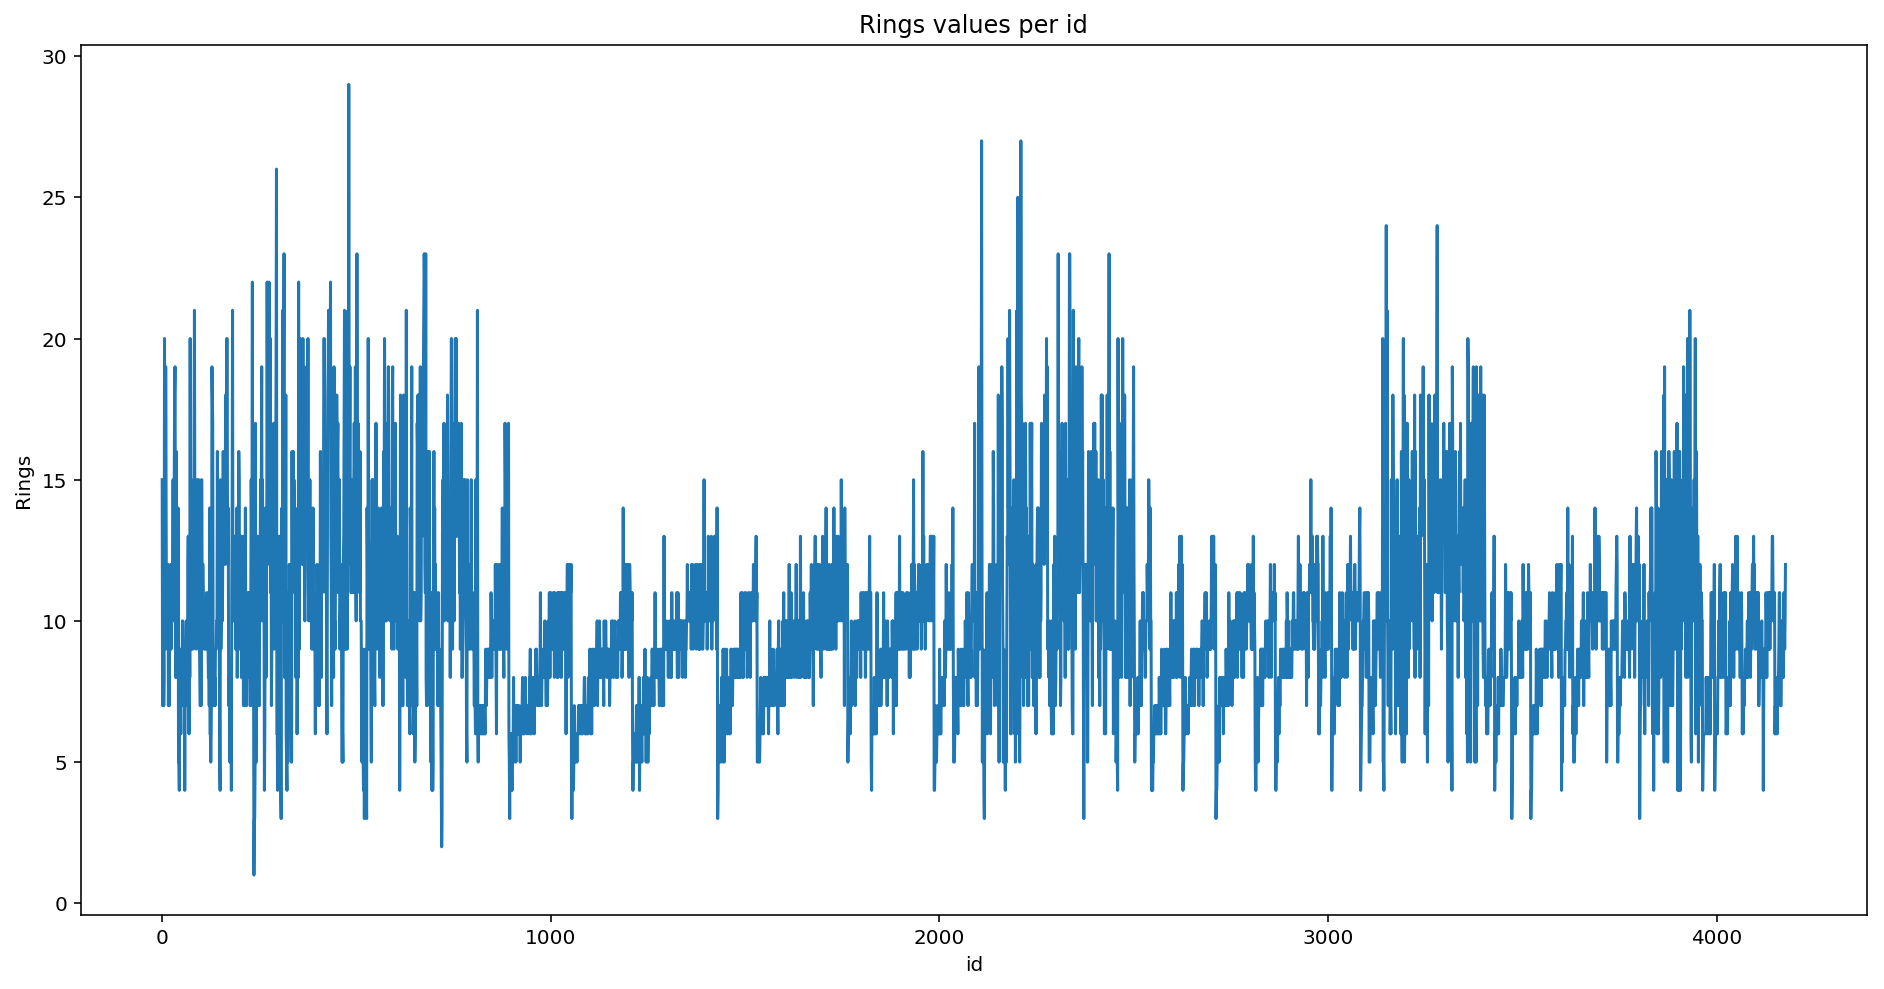

In [9]:
plt.figure(figsize=(16,8))
plt.plot(list(data['id']),list(data['Rings']))
plt.title('Rings values per id')
plt.xlabel('id')
plt.ylabel('Rings')
plt.show()

查看Rings的偏度值

In [10]:
stats.mstats.skew(data['Rings']).data

array(1.11370177)

偏度值比1大，说明数据是倾斜的。不利于数据建模。我们利用对数变换np.log，使倾斜降低。

In [11]:
stats.mstats.skew(np.log(data['Rings'])).data

array(-0.23405841)

两种分布对比

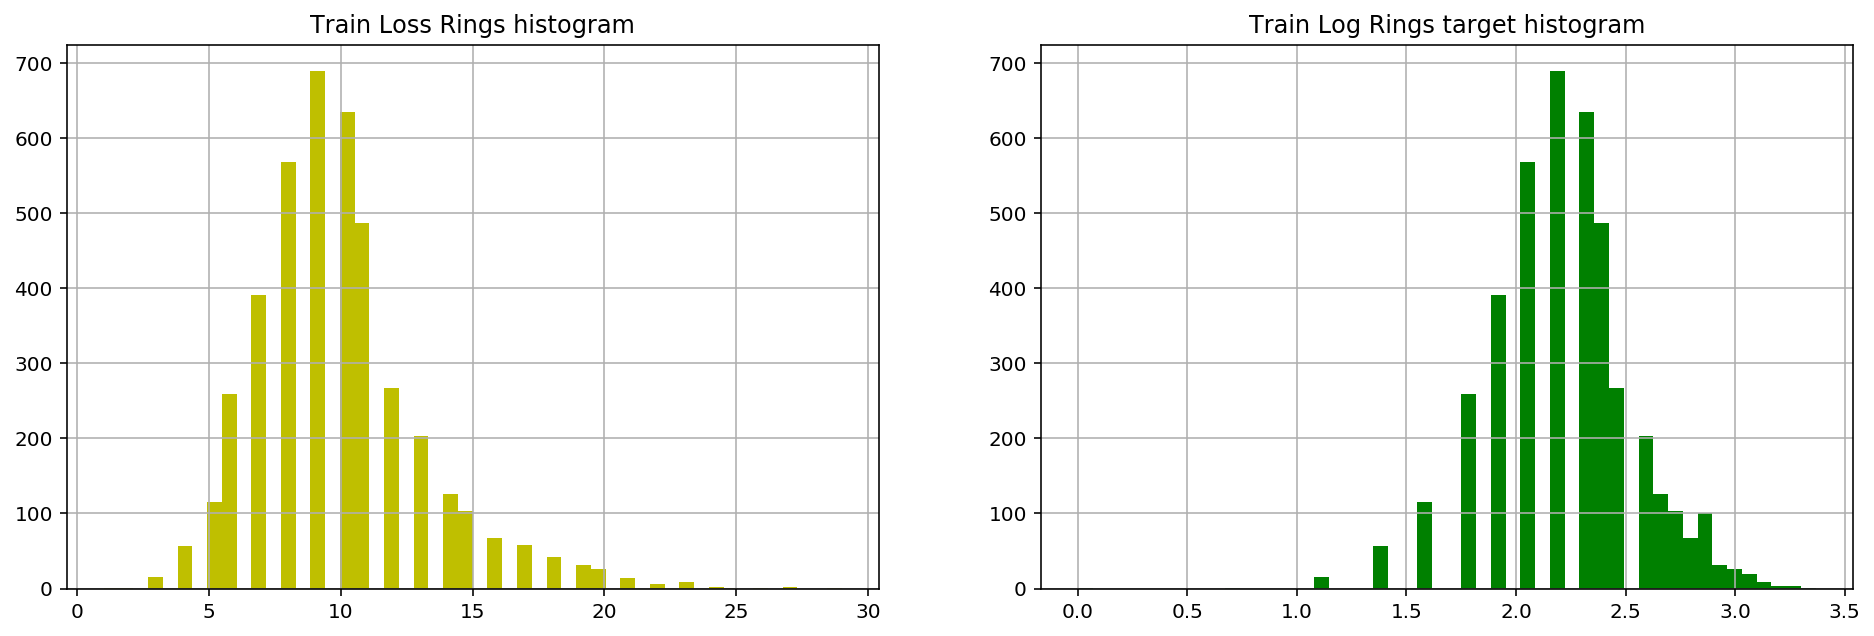

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(data['Rings'], bins=50,color='y')
ax1.set_title('Train Loss Rings histogram')
ax1.grid(True)
ax2.hist(np.log(data['Rings']), bins=50, color='g')
ax2.set_title("Train Log Rings target histogram")
ax2.grid(True)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000292DEFCEA20>,
      dtype=object)

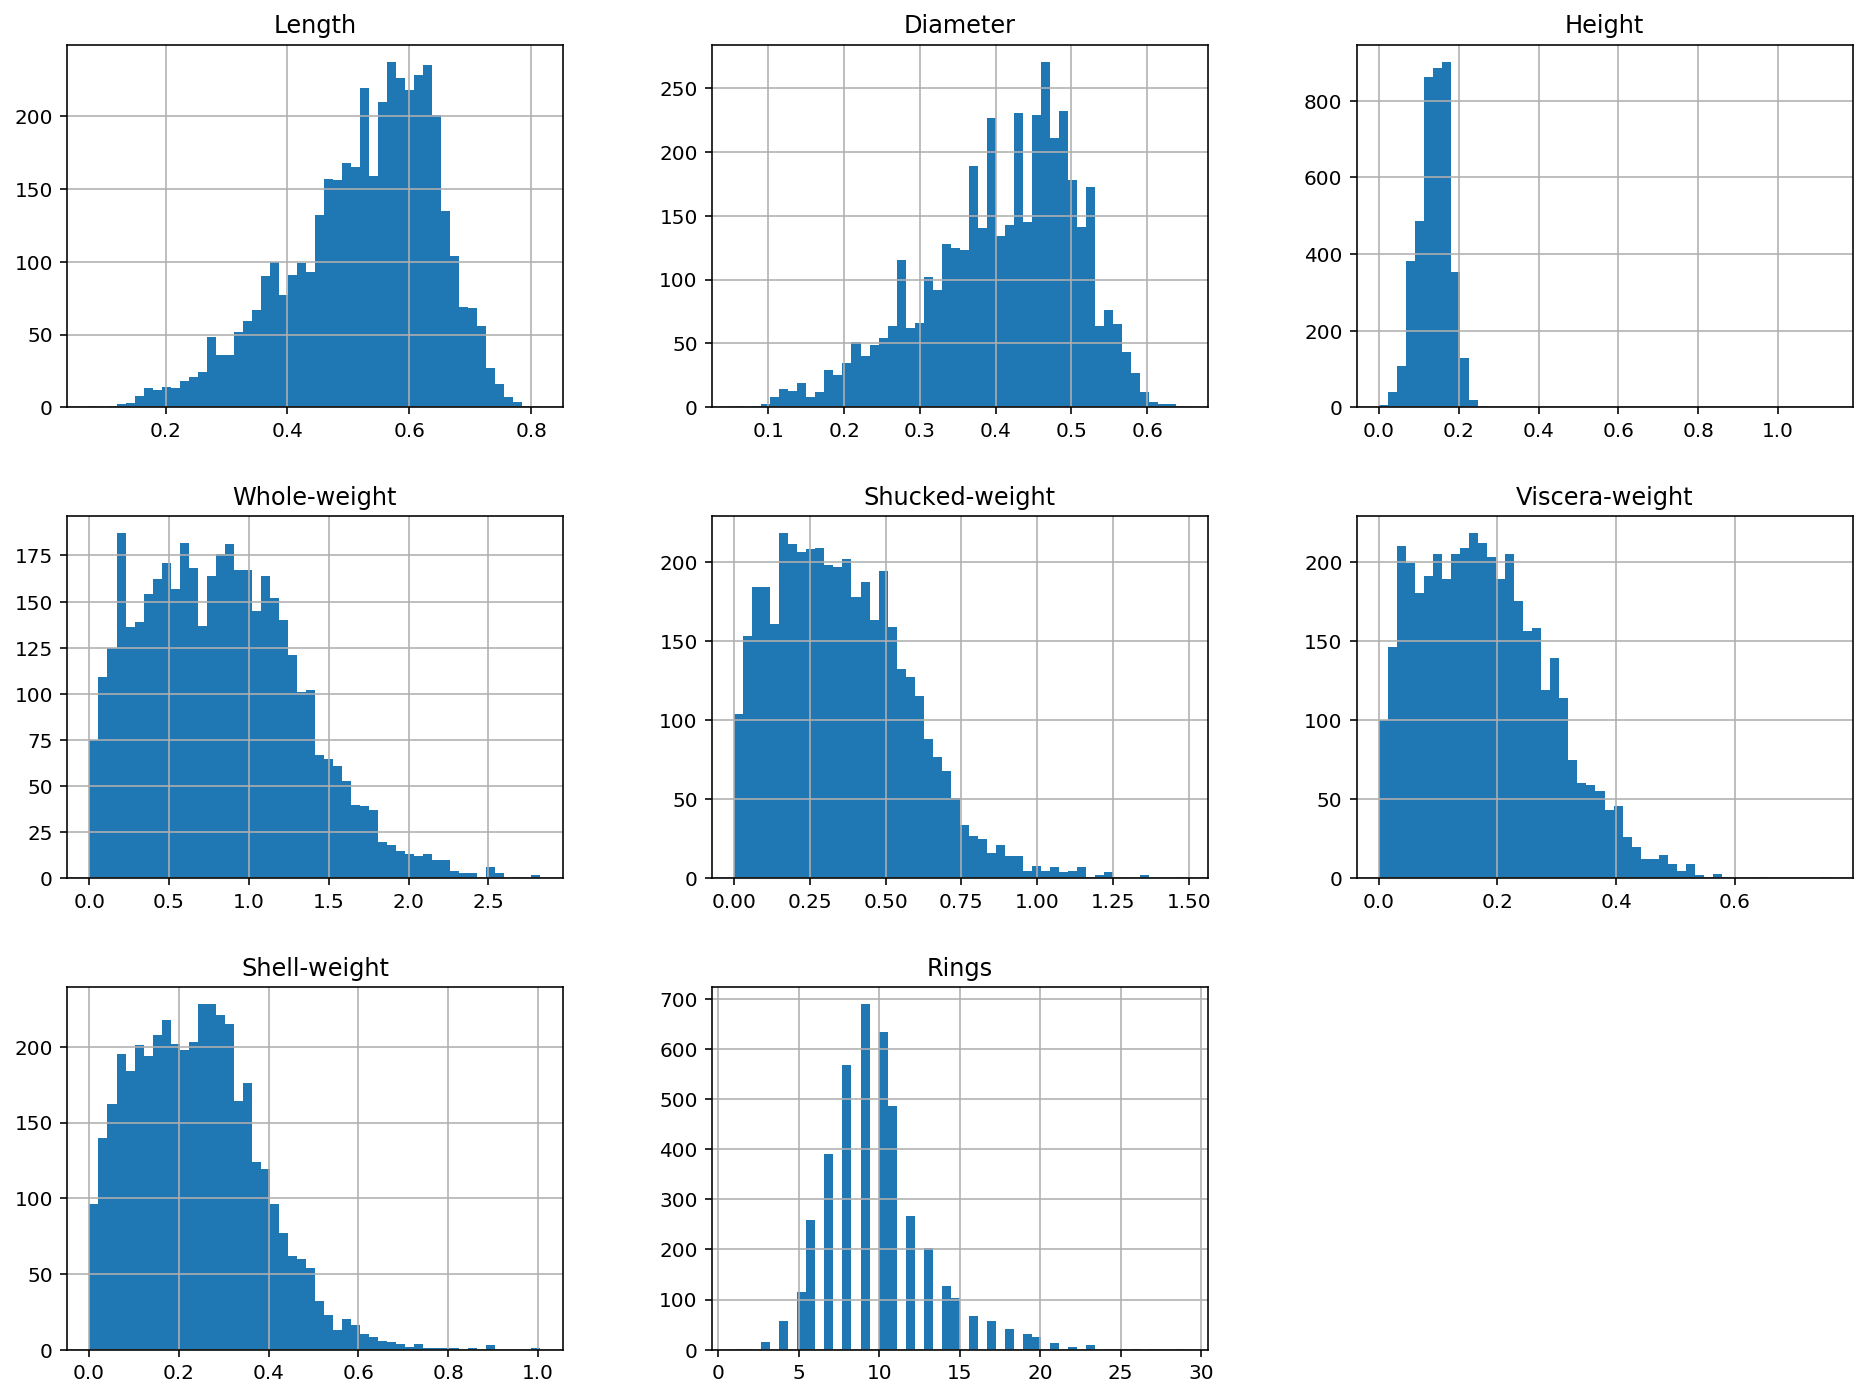

In [13]:
data[cont_features].hist(bins=50,figsize=(16,12))

查看特征之间相关性

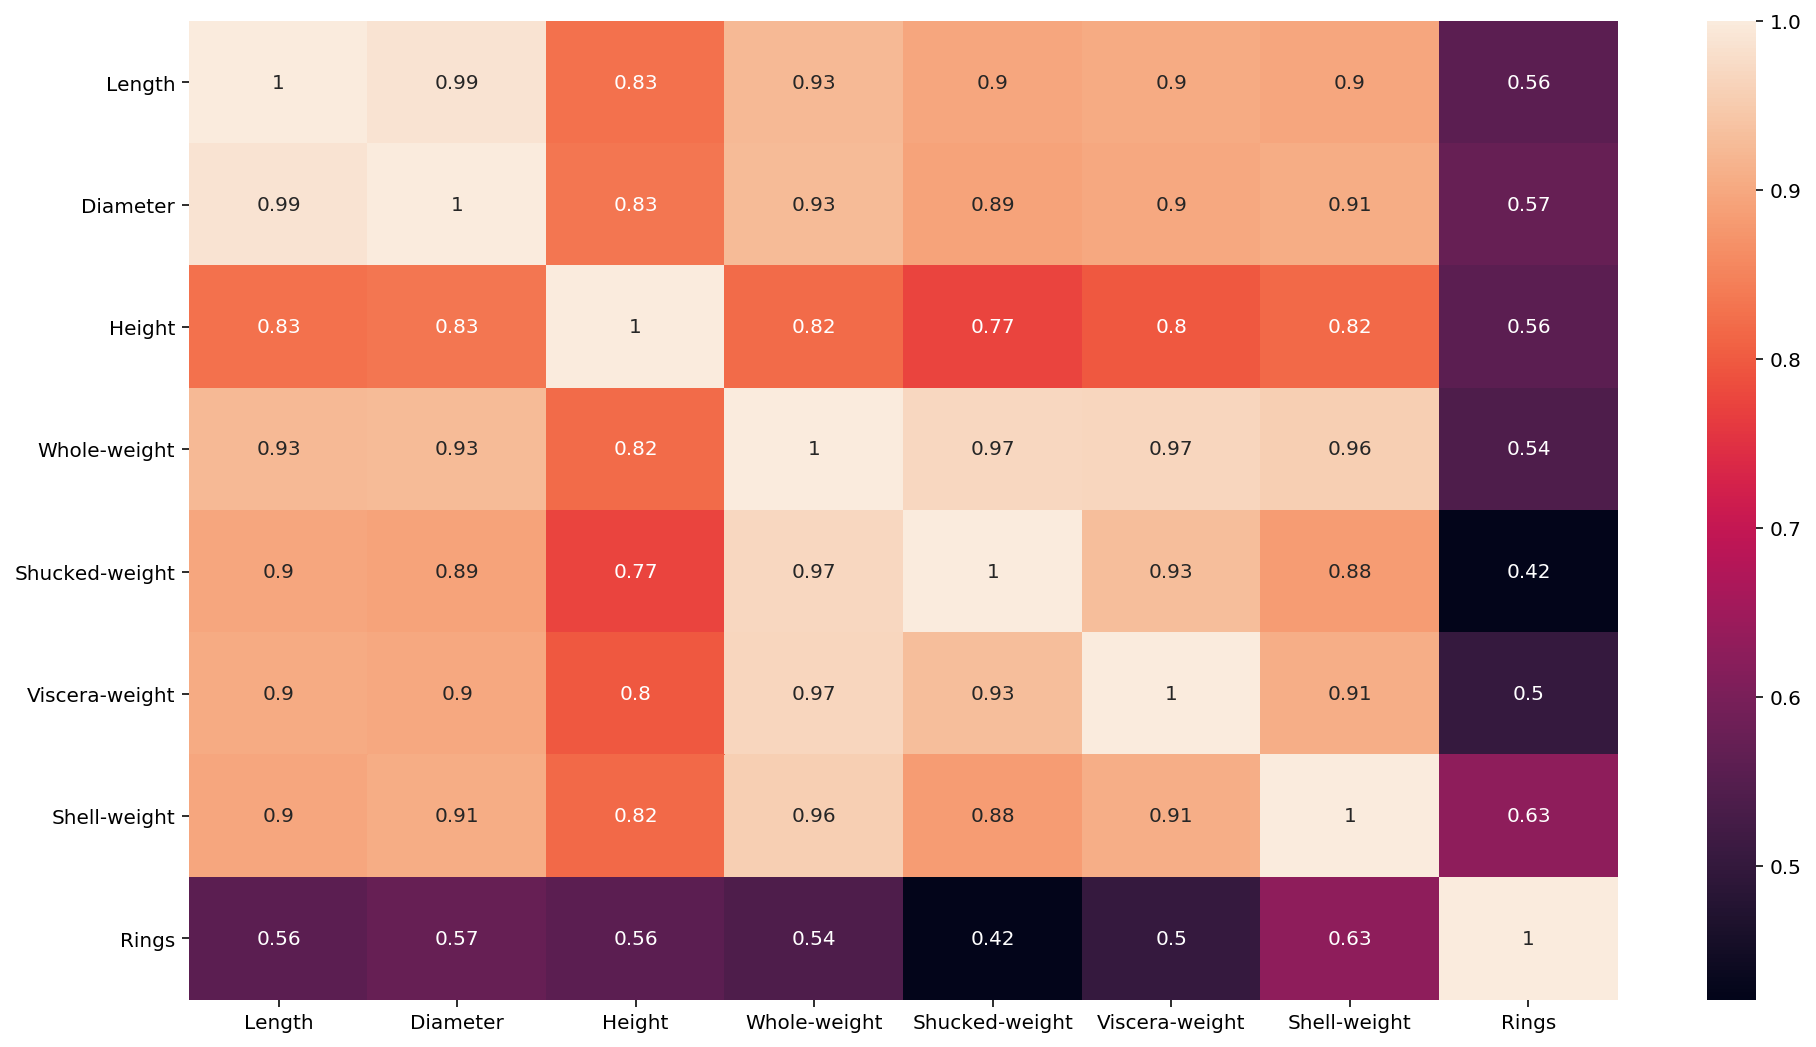

In [14]:
plt.subplots(figsize=(16,9))
correlation_mat = data[cont_features].corr()
sns.heatmap(correlation_mat,annot=True)

## 三、XGBoost调参策略
### 3.0、XGBoost参数解析
* booster : gbtree, 用什么方法进行结点分裂。梯度提升树来进行结点分裂。
* objective : multi softmax, 使用的损失函数，softmax 是多分类问题
* num_class : 10, 类别数，与 multi softmax 并用
* gamma : 损失下降多少才进行分裂
* max_depth : 12, 构建树的深度, 越大越容易过拟合
* lambda : 2, 控制模型复杂度的权重值的L2正则化项参数，参数越大。模型越不容易过拟合。
* subsample : 0.7 , 随机采样训练样本，取70%的数据训练
* colsample_bytree : 0.7, 生成树时进行的列采样
* min_child_weight : 3, 孩子节点中最小的样本权重和，如果一个叶子结点的样本权重和小于 min_child_weight 则拆分过程结果
* slient : 0, 设置成 1 则没有运行信息输出，最好是设置为0
* eta : 0.007, 如同学习率。前面的树都不变了，新加入一棵树后对结果的影响占比
* seed : 1000
* Thread : 7, cup 线程数
  
### 3.1、数据预处理
对Rings列做对数变换

In [15]:
data['Rings'] = np.log(data['Rings'])
data.head()

,Sex,Length,Diameter,Height,Whole-weight,Shucked-weight,Viscera-weight,Shell-weight,Rings,id
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2.708050,1
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1.945910,2
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2.197225,3
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,2.302585,4
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1.945910,5


划分训练集和测试集

In [16]:
col_features = ['Length','Diameter','Height','Whole-weight','Shucked-weight','Viscera-weight','Shell-weight']
data_features = data[col_features]
data_label = data['Rings']
train_x,test_x,train_y,test_y = train_test_split(data_features,data_label,test_size=0.2,random_state=0)

查看训练集和测试集大小

In [17]:
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)
print ("Xtest:", test_x.shape)
print ("ytest:", test_y.shape)

Xtrain: (3341, 7)
ytrain: (3341,)
Xtest: (836, 7)
ytest: (836,)


### 3.2、初始化XGBoost模型
首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差MAE来衡量  
mean_absolute_error(np.exp(y), np.exp(yhat))。  

定义计算损失值的函数xg_eval_mae(yhat, dtrain)

In [18]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

将数据类型转换成库可以使用的底层格式。

In [19]:
dtrain = xgb.DMatrix(train_x, train_y)   

定义SGBoost模型参数

In [20]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.7,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 xgb.cv

In [21]:
%%time

#feval:评估策略
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

我们得到了第一个基准结果：MAE＝1.540285

<Figure size 432x288 with 0 Axes>

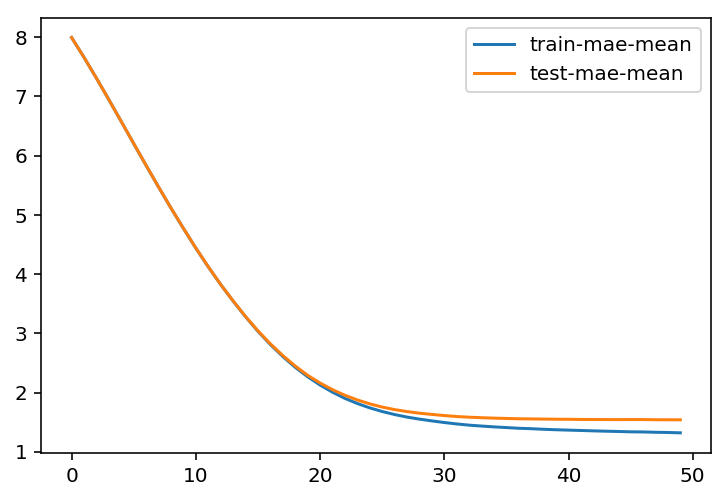

In [22]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot() 

上面是我们第一个模型
* 没有发生过拟合
* 只建立了50个树模型

In [23]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

修改树模型的个数，查看对结果的影响

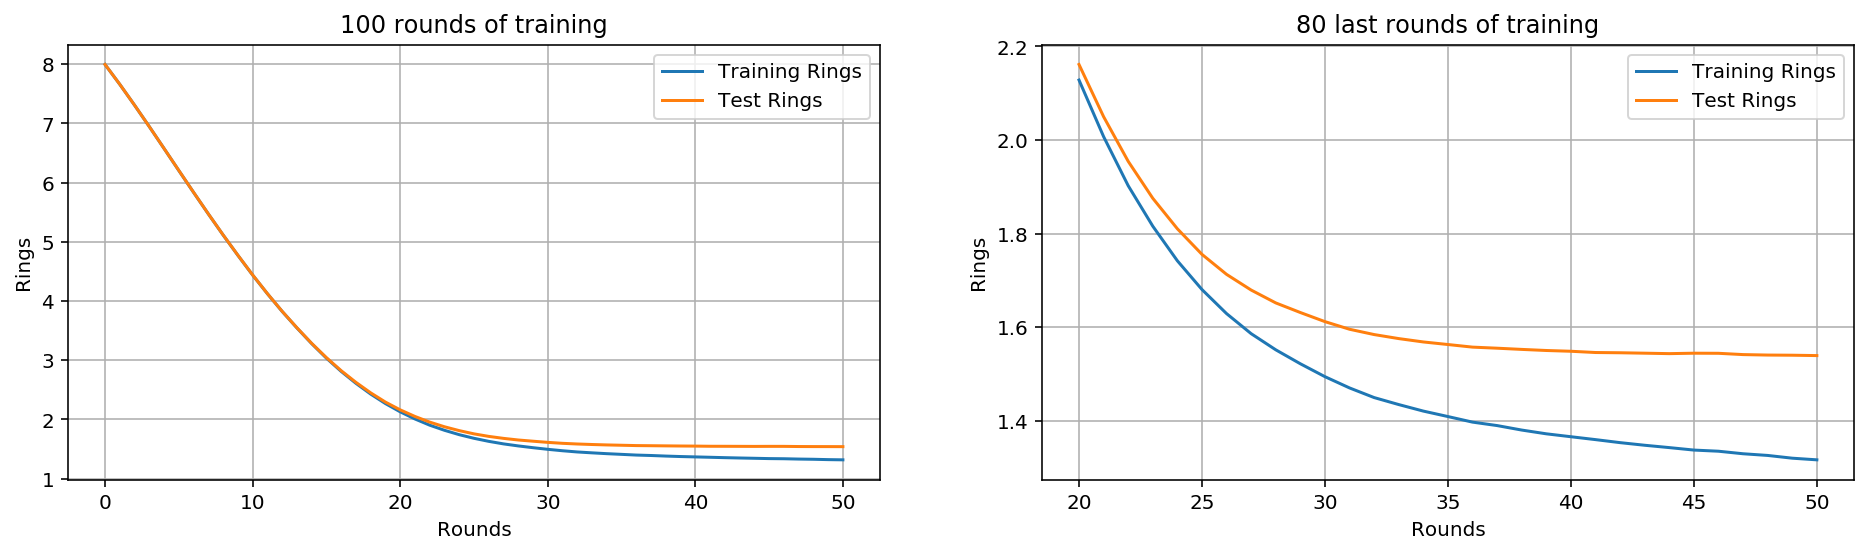

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Rings')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Rings', 'Test Rings'])

ax2.set_title('80 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Rings')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[20:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Rings', 'Test Rings'])

100个树模型所得到的MAE=1.5279优于50个树模型所得到的MAE=1.5314

### 3.3、XGBoost模型参数调节
* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

#### step1、基准模型

In [25]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})#默认参数
        
    def fit(self, x_train, y_train):
        '''
        #数据类型转换,#用参数去训练xgboost模型
        '''
        dtrain = xgb.DMatrix(x_train, y_train) 
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self 

In [26]:
#衡量标准
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

bst.kfold(train_x, train_y, nfold=5)

[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

train-rmse-mean    0.174626
train-rmse-std     0.003162
test-rmse-mean     0.195732
test-rmse-std      0.003115
train-mae-mean     1.375978
train-mae-std      0.032220
test-mae-mean      1.535066
test-mae-std       0.054274
Name: 49, dtype: float64

按照训练集处理方式，处理我们的测试集

In [27]:
#数据类型转换成库可以使用的底层格式。
dtest_x = xgb.DMatrix(test_x)
#dtest_x
#得到我们想要的测试集


#预测命令：
#xgb.predict(dtest_x)
dtest_y = bst.predict(test_x)

dtest_y[1],len(dtest_y)

[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(2.282325, 836)

In [28]:
#math.exp(test_y[0])
test_exp_y= np.zeros(len(dtest_y))
for i in range(len(dtest_y)):
    test_exp_y[i] = math.exp(dtest_y[i])
test_exp_y.shape

(836,)

这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [29]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}

In [30]:
%%time

#交叉验证 网格搜索
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring = mae_scorer)

grid.fit(train_x, train_y.values)

[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:41] WARNING: C

[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:55] WARNING: C

[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

Wall time: 20.4 s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000292DF63F860>,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [31]:
print(grid.cv_results_['mean_test_score'])
print(grid.cv_results_['params'])
print('************************************')
print(grid.best_params_)
print('************************************')
print(grid.best_score_ )

[-1.45333347 -1.44857154 -1.45749137 -1.38257751 -1.38940583 -1.40065282
 -1.32451342 -1.33477813 -1.36044623 -1.25198758 -1.27806232 -1.31583943
 -1.1892672  -1.22038736 -1.26343016]
[{'max_depth': 4, 'min_child_weight': 1}, {'max_depth': 4, 'min_child_weight': 3}, {'max_depth': 4, 'min_child_weight': 6}, {'max_depth': 5, 'min_child_weight': 1}, {'max_depth': 5, 'min_child_weight': 3}, {'max_depth': 5, 'min_child_weight': 6}, {'max_depth': 6, 'min_child_weight': 1}, {'max_depth': 6, 'min_child_weight': 3}, {'max_depth': 6, 'min_child_weight': 6}, {'max_depth': 7, 'min_child_weight': 1}, {'max_depth': 7, 'min_child_weight': 3}, {'max_depth': 7, 'min_child_weight': 6}, {'max_depth': 8, 'min_child_weight': 1}, {'max_depth': 8, 'min_child_weight': 3}, {'max_depth': 8, 'min_child_weight': 6}]
************************************
{'max_depth': 8, 'min_child_weight': 1}
************************************
-1.1892671957273397


网格搜索发现的最佳结果: {'max_depth': 8, 'min_child_weight': 1}, -1.1892671957273397

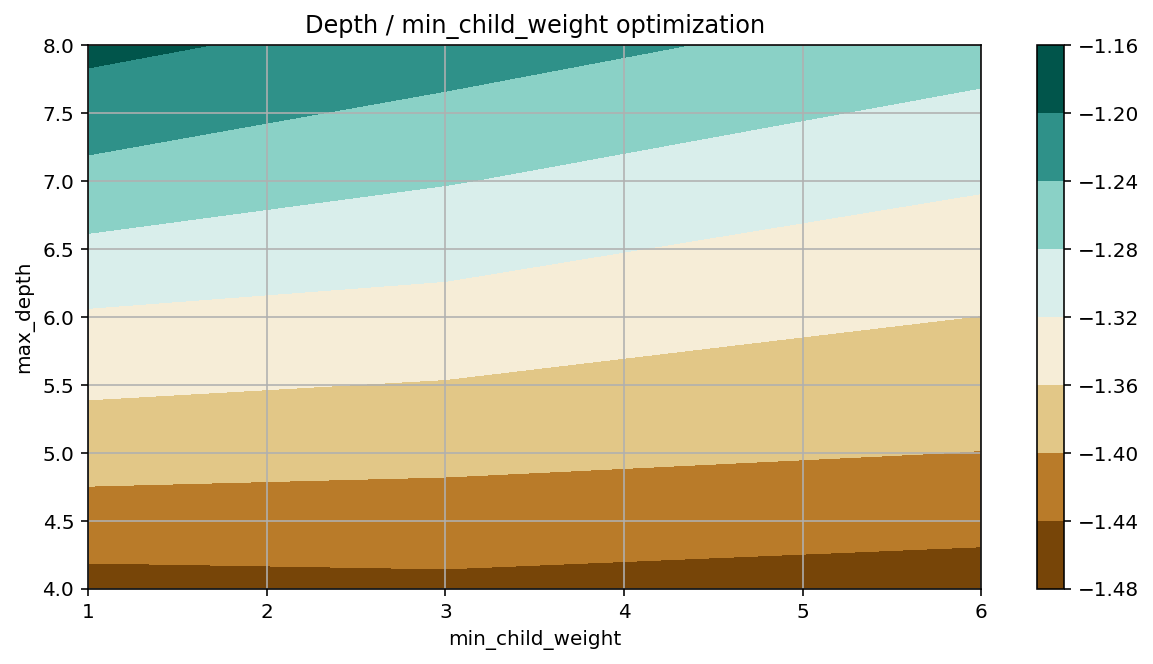

In [32]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i)
        _params_mae.append(i)
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])] 

_,scores =  convert_grid_scores(grid.cv_results_['mean_test_score'])
scores = scores.reshape(5,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
# plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
# plt.annotate('Good for depth=7', xy=(5.98, 7.05), xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

#### step3、调节gamma降低过拟合风险

In [33]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=1,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:04] WARNING: C

[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000292DEF49198>,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [34]:
grid.cv_results_['mean_test_score'], grid.best_params_, grid.best_score_

(array([-1.1892672 , -1.30236852, -1.39027255, -1.43205973, -1.47277266]),
 {'gamma': 0.0},
 -1.1892671957273397)

#### step4、调节样本采样方式 subsample 和 colsample_bytree

In [35]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0, num_boost_round=50, max_depth=8, min_child_weight=1),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 20 s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000292DEF49278>,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [36]:
grid.cv_results_['mean_test_score'], grid.best_params_, grid.best_score_

(array([-1.12346418, -1.07514185, -1.05757797, -1.12346418, -1.07514185,
        -1.05757797, -1.09580692, -1.08480962, -1.06715373]),
 {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
 -1.0575779686098596)

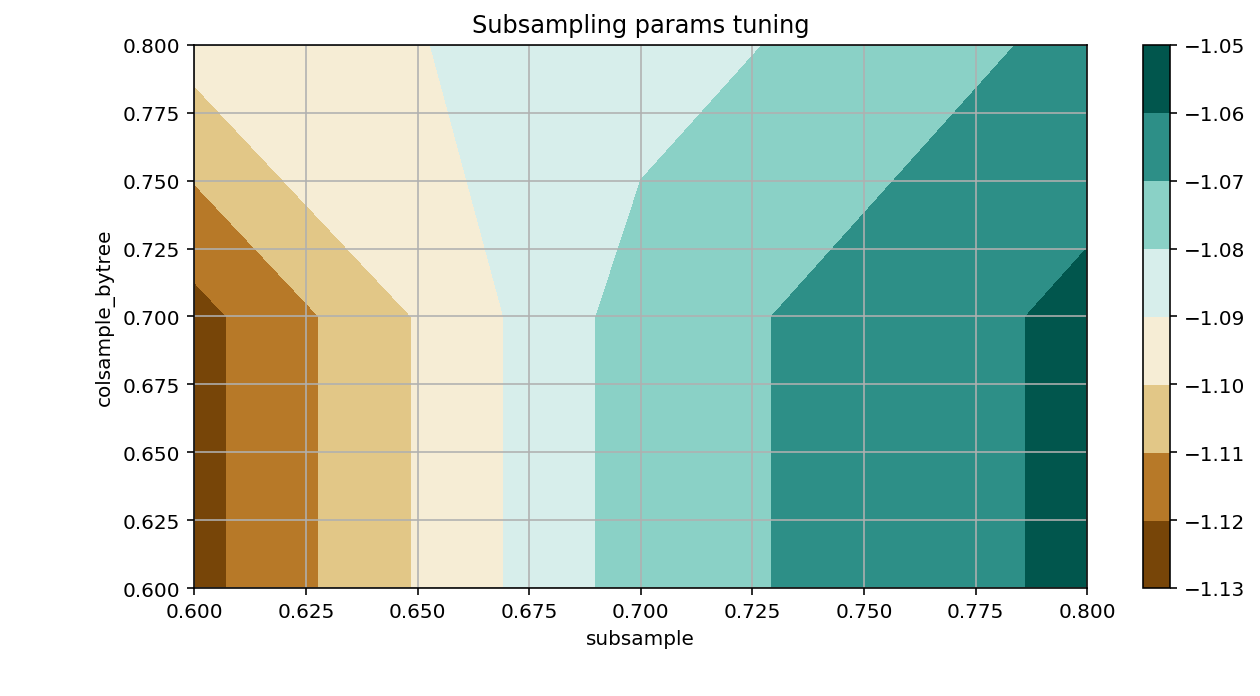

In [37]:
_, scores =  convert_grid_scores(grid.cv_results_['mean_test_score'])
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show() 

在当前的预训练模式的具体案例，我得到了下面的结果：  
```
 {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
 -1.0575779686098596
```

#### step5、减小学习率并增大树个数
参数优化的最后一步是降低学习速度，同时增加更多的估计量

In [38]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0, max_depth=8, min_child_weight=1,
                                        colsample_bytree=0.6, subsample=0.8),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values) 

[00:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:45] WARNING: C

[00:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 19 s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000292DEF49828>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [39]:
grid.cv_results_['mean_test_score'], grid.best_params_, grid.best_score_

(array([-0.39556547, -0.5159855 , -0.62624599, -0.81552424, -1.05757797,
        -1.18896201, -1.69160937, -2.33163946, -3.41736333]),
 {'eta': 0.5},
 -0.39556547231381967)

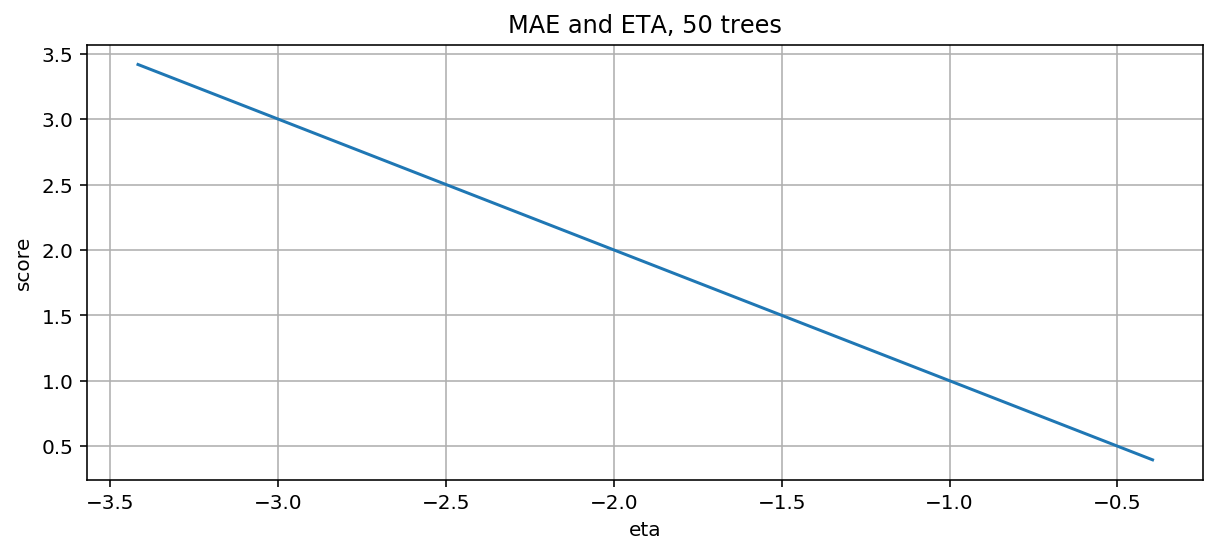

In [40]:
eta, y = convert_grid_scores(grid.cv_results_['mean_test_score'])
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

继续增大树的个数

In [41]:
%%time

xgb_param_grid = {'eta':[0.9,0.8,0.7,0.6,0.5,0.4]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0, max_depth=8, min_child_weight=1,
                                        colsample_bytree=0.6, subsample=0.8),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[00:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:02:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[00:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 44.8 s


GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000292DFD24B00>,
             param_grid={'eta': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [42]:
grid.cv_results_['mean_test_score'], grid.best_params_, grid.best_score_

(array([-0.00438923, -0.00478345, -0.00521952, -0.00812074, -0.01579157,
        -0.0375062 ]),
 {'eta': 0.9},
 -0.0043892289143132816)

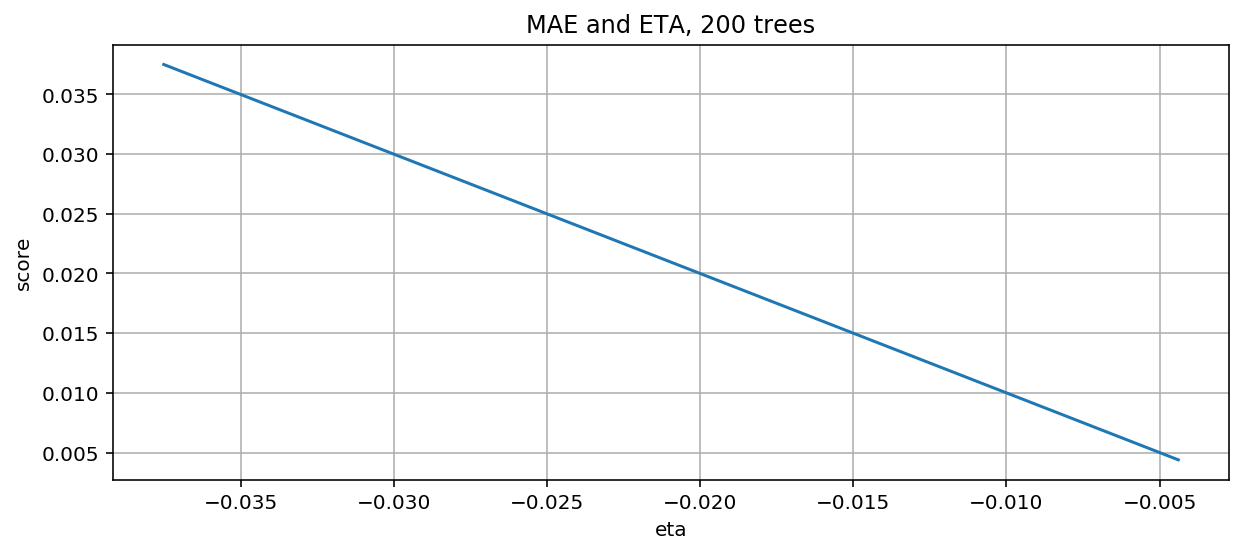

In [43]:
eta, y = convert_grid_scores(grid.cv_results_['mean_test_score'])
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [44]:
%%time

# Final XGBoost model

bst = XGBoostRegressor(num_boost_round=200, eta=0.9, gamma=0, max_depth=8, min_child_weight=1,
                                        colsample_bytree=0.6, subsample=0.8)
cv = bst.kfold(train_x, train_y, nfold=5)

[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

In [45]:
# 查看交叉熵
cv

train-rmse-mean    0.190731
train-rmse-std     0.007295
test-rmse-mean     0.218246
test-rmse-std      0.003350
train-mae-mean     1.483660
train-mae-std      0.065025
test-mae-mean      1.691612
test-mae-std       0.039125
Name: 1, dtype: float64

In [46]:
pre_y = bst.predict(test_x)
# plt.plot(pre_y)
# plt.plot(test_y)
# plt.show()


[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [47]:
test_y.shape

(836,)

In [48]:
pre_y.shape

(836,)

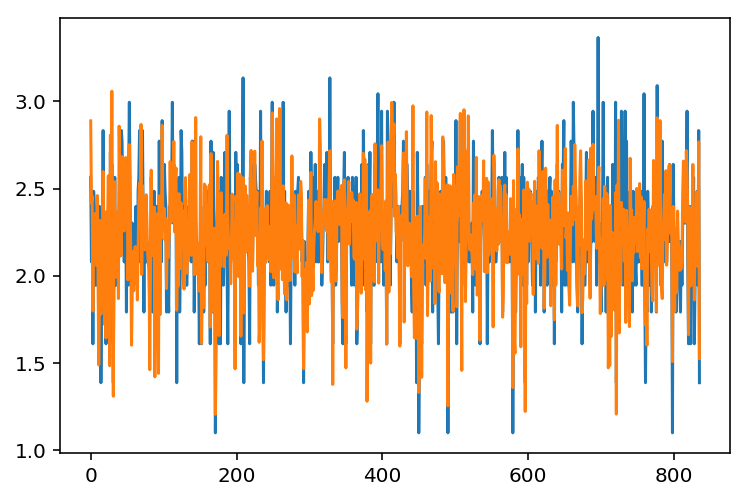

In [49]:
plt.plot(test_y.values)
plt.plot(pre_y)
plt.show()